In [1]:
import os
import pandas as pd
import cv2

In [2]:
os.makedirs("./all_data/en_train_filtered/__results___files",exist_ok=True)

In [3]:
os.makedirs("./all_data/en_val/__results___files",exist_ok=True)

In [2]:
import os
import json
from collections import Counter
from tqdm import tqdm
import glob

In [7]:
# !pip install pylatexenc
from pylatexenc.latex2text import LatexNodes2Text
latexconv = LatexNodes2Text()

In [8]:
%%time

import os
import json
from collections import Counter
from tqdm import tqdm
def convert_to_bbox(polygon):
    return [polygon['x0'], polygon['y0'], polygon['x1'], polygon['y1'],polygon['x2'],polygon['y2'],polygon['x3'],polygon['y3']]

import hashlib
import random
from PIL import Image, ImageDraw
import numpy as np
import os

def point_to_bbox(point, k=5):
    x = point['x']
    y = point['y'] 
    return [x, y]

def point_to_bbox_tuple(x,y, k=5):
    return [x, y]
def get_id(texts,i):
    for k in texts:
        if i==k["id"]:
            return k
def get_bounding_box(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    x_min = min(xs)
    y_min = min(ys)
    x_max = max(xs)
    y_max = max(ys)
    return [x_min, y_min, x_max - x_min, y_max - y_min]
def create_square(point, k=5):
    if type(point)==dict:
        x,y = point["x"],point["y"]
    else:
        x,y =point
    half_k = k / 2.0

    # Define the corners of the square
    corners = [x - half_k, y - half_k,x + half_k, y - half_k,x + half_k, y + half_k,x - half_k, y + half_k]
    return corners
def polygon_to_bbox(polygon):
    # Create list of x and y coordinates
    x_coords = polygon[0::2]
    y_coords = polygon[1::2]

    # Compute minimum and maximum coordinates
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Calculate the center of the bounding box
    x_center = (x_min + x_max) / 2.0
    y_center = (y_min + y_max) / 2.0

    # Calculate the width and height of the bounding box
    width = x_max - x_min
    height = y_max - y_min

    # Return the bounding box in the format [x, y, width, height]
    return [x_center, y_center, width, height]
def get_line_bboxes(v,ctype=None):
    texts = v["text"]
    polygon_info = []
    point_info = []
    for tinf in v["axes"]["x-axis"]["ticks"]:
        bbox_label = get_id(texts,tinf["id"])
        polygon_info.append(bbox_label)

    for tinf in v["axes"]["y-axis"]["ticks"]:
        bbox_label = get_id(texts,tinf["id"])
        polygon_info.append(bbox_label)
    return polygon_info
import re

def sanitize_filename(filename):
    # This regex will match any character that is not a letter, number, space, hyphen, underscore, or dot.
    invalid_chars_pattern = r'[\\/:*?"<>|]'
    # Replace invalid characters with an underscore.
    sanitized_filename = re.sub(invalid_chars_pattern, '_', filename)
    return sanitized_filename

def save_cropped_patches(image_path, list_of_dicts,savepath,imno,savednames,savedtext):
    # Open the image
    img = Image.open(image_path)
    im_basename = os.path.basename(image_path).split(".")[0]
    # For each dict in the list
    for d in list_of_dicts:
        polygon = d['polygon']

        # Create polygon points in the order [(x0, y0), (x1, y1), (x2, y2), (x3, y3)]
        poly_points = [(polygon['x0'], polygon['y0']), (polygon['x1'], polygon['y1']), (polygon['x2'], polygon['y2']), (polygon['x3'], polygon['y3'])]

        # Create a blank mask image
        polygon_img = Image.new('L', (img.width, img.height), 0)
        
        # Draw the polygon on the mask image
        ImageDraw.Draw(polygon_img).polygon(poly_points, outline=1, fill=1)

        # Get the bounding box of the polygon
        bbox = polygon_img.getbbox()

        # Crop the bounding box directly from the original image
        bbox_cropped_image = img.crop(bbox)
        
        ttxt = latexconv.latex_to_text(d['text'])
        if len(ttxt) == 0 or any([x in im_basename for x in "()/"]):
            continue

        # Save the cropped bounding box with the filename convention: {dict["text"]}_{randomhash}.png
        bbox_cropped_image.convert('RGB').save(os.path.join(savepath, f"{im_basename}_{imno}.jpg"))
        savednames.append(f"{im_basename}_{imno}.jpg")
        savedtext.append(ttxt)
        imno += 1
    return imno

train_image_names = []
train_texts = []


CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 28.1 µs


In [9]:
train_images = sorted(glob.glob("./ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/images/*/*"))
train_annots = sorted(glob.glob("./ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/annotations_JSON/*/*"))

In [10]:
train_images1 = {}
for x in sorted(glob.glob("./ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images/*/*/*")):
    train_images1["".join(os.path.split(x)[-1].split(".")[:-1])] = x
train_annots1 = {}
for x in sorted(glob.glob("./ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/final_full_GT/*/*/*.json")):
    train_annots1["".join(os.path.split(x)[-1].split(".")[:-1])] = x

In [11]:
index=0
for imgpth,annot in tqdm(zip(train_images,train_annots)):
    v = json.load(open(annot))
    if v["task2"] is None:
        continue
    polygons = v["task2"]["output"]["text_blocks"]
    index = save_cropped_patches(imgpth,polygons,"./all_data/en_train_filtered/__results___files/",index,train_image_names,train_texts)

22923it [01:36, 236.50it/s] 


In [12]:
index=0
for imgpth,annot in tqdm(zip(train_images1,train_annots1)):
    v = json.load(open(train_annots1[annot]))
    if v["task2"] is None or v["task2"]["output"] is None:
        continue
    polygons = v["task2"]["output"]["text_blocks"]
    index = save_cropped_patches(train_images1[annot],polygons,"./all_data/en_train_filtered/__results___files/",index,train_image_names,train_texts)

13259it [00:30, 429.01it/s]  


In [13]:
import os
import json
from collections import Counter
from tqdm import tqdm
# define directories
IMAGE_DIR = '../datasets/dataset/train/images'
ANNOTATIONS_DIR = '../datasets/dataset/train/annotations'

# get the list of images
image_filenames = os.listdir(IMAGE_DIR)

json_files = json.load(open("../datasets/dataset/data.json"))

In [14]:
valid_files = set([x.split(".")[0] for x in os.listdir("../datasets/dataset/keypoint/labels/valid/")])
train_files = set([x.split(".")[0] for x in os.listdir("../datasets/dataset/keypoint/labels/train/")])
valid_files = {k:json_files[k] for k in json_files if k in valid_files}
train_files = {k:json_files[k] for k in json_files if k in train_files}

In [15]:
ROOT="../datasets/dataset/keypoint/images/train"
index=0
for k in tqdm(train_files):
    imgpth=os.path.join(ROOT,k+".jpg")
    v = train_files[k]
    
    imgpth=os.path.join(ROOT,k+".jpg")
    polygons = get_line_bboxes(v, v['chart-type'])
    index = save_cropped_patches(imgpth,polygons,"./all_data/en_train_filtered/__results___files/",index,train_image_names,train_texts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60312/60312 [09:48<00:00, 102.40it/s]


In [16]:
len(valid_files),len(train_files)

(223, 60312)

In [17]:
train_df = pd.DataFrame(list(zip(train_image_names, train_texts)),
               columns =['filename', 'words'])
train_df.to_csv('./all_data/en_train_filtered/labels.csv',index=False)

In [18]:
valid_image_names,valid_texts=[],[]

In [19]:
ROOT="../datasets/dataset/keypoint/images/valid"
index=0
for k in tqdm(valid_files):
    imgpth=os.path.join(ROOT,k+".jpg")
    img = cv2.imread(imgpth)
    image = img.copy()
    h,w,_ = img.shape
    v = valid_files[k]
    
    imgpth=os.path.join(ROOT,k+".jpg")
    polygons = get_line_bboxes(v, v['chart-type'])
    index = save_cropped_patches(imgpth,polygons,"./all_data/en_val/__results___files/",index,valid_image_names,valid_texts)
valid_df = pd.DataFrame(list(zip(valid_image_names, valid_texts)),
               columns =['filename', 'words'])
valid_df.to_csv('./all_data/en_val/labels.csv',index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:02<00:00, 103.89it/s]


In [11]:
# train_df = pd.read_csv("./all_data/en_train_filtered/__results___files/labels.csv", sep='^([^,]+),', engine='python', usecols=['filename', 'words'], keep_default_na=False)
# train_df = train_df[train_df.filename.apply(lambda x: ".jpg" in x)]
# train_df = train_df.dropna().reset_index(drop=True)
# train_df.to_csv("./all_data/en_train_filtered/__results___files/labels.csv",index=False)

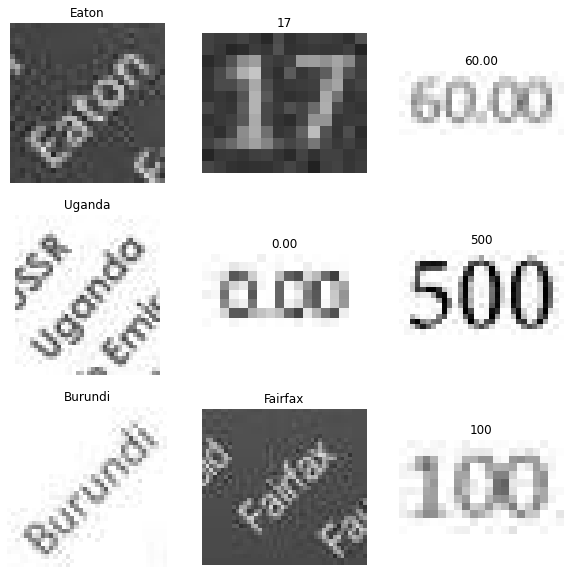

In [23]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def sample_images(folder_path, tdf,num_samples=9):
    # Get all files in the directory
    all_files = os.listdir(folder_path)

    # Filter list for only jpg and png files
    image_files = [file for file in all_files if file.endswith(('.jpg', '.png'))]

    # Randomly sample the image files
    sampled_files = tdf.sample(num_samples)

    # Determine grid size for plotting
    grid_size = int(num_samples**0.5)

    # Create subplots
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10,10))

    for i, (file,word) in enumerate(zip(sampled_files.filename,sampled_files.words)):
        # Open image file
        img = Image.open(os.path.join(folder_path, file.replace(".png",".jpg")))
        
        # Add to subplot
        axs[i//grid_size, i%grid_size].imshow(img)
        axs[i//grid_size, i%grid_size].axis('off')
        axs[i//grid_size, i%grid_size].set_title(word)

    # Remove empty subplots
    if num_samples < grid_size**2:
        for i in range(num_samples, grid_size**2):
            fig.delaxes(axs.flatten()[i])
            
    # Display the plot
    plt.show()

# call the function
sample_images('./all_data/en_train_filtered/__results___files',train_df)